In [110]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
import os
import shutil

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tools_edmz.atlas import Atlas
from tools_edmz.process_df import count_cells, group_counts, collapse_structures, filter_df, normalize_df

atlas = Atlas(json_version="clearmap")

import pandas as pd


from tools_edmz.params import BASE_FOLDER_DATA, BASE_FOLDER_FIGS

In [112]:
# this overrides imports 


def count_cells(path: str) -> pd.DataFrame:
    """
    counts cells from one file of type cells.feather
    returns df with columns id, hemisphere, cell_count and one row per structure x hemisphere
    """
    counts = pd.read_feather(path).value_counts().reset_index().rename(columns={0:'count'})
    return counts

def group_counts(counts_s, sample_names) -> pd.DataFrame:
    """
    groups several cell_counts together; sample_names are the names of the samples
    returns df with columns id, hemisphere, and one column per sample
    """
    counts_s = [counts.set_index(['id', ]) for counts in counts_s]
    df = pd.concat(counts_s, axis=1).fillna(0)
    df.columns = sample_names
    df = df.reset_index()
    return df

def collapse_structures(df: pd.DataFrame, map_collapse) -> pd.DataFrame:
    """
    collapses structures according to a dict map_collapse (id -> new_id)
    ids not in map_collapse are kept
    """
    df['id'] = df['id'].map(lambda x: map_collapse.get(x, x))
    counts = (df.groupby(['id', ], as_index=False)
              .sum()
              )
    return counts

def filter_df(df: pd.DataFrame, structure_ids, exclude: bool=False) -> pd.DataFrame:
    """
    returns a df that includes only the
    """
    if exclude is False:
        df = df.loc[df["id"].isin(structure_ids) ].reset_index(drop=True)
        return df.copy()
    else:
        df = df.loc[~(df["id"].isin(structure_ids))].reset_index(drop=True)
        return df.copy()

def normalize_df(df: pd.DataFrame, df_normalize: pd.DataFrame) -> pd.DataFrame:
    df = df.set_index(['id']).copy()
    df_normalize = df_normalize.set_index(['id']).copy()
    normalize_100 = df_normalize.sum(axis=0)
    df = df/normalize_100 * 100
    return df.reset_index()


In [113]:
print(BASE_FOLDER_DATA)
print(BASE_FOLDER_FIGS)

/home/etienne.doumazane/data
/home/etienne.doumazane/figures


In [114]:
FOLDER_DATA = "/home/etienne.doumazane/data/AnaMarta/"
FOLDER_FIGS = "/home/etienne.doumazane/figures/Anamarta/20220927/"

In [115]:
[fname for fname in os.listdir(FOLDER_DATA) if fname.endswith('feather')]

['727.feather',
 '726.feather',
 '761.feather',
 '728.feather',
 '769.feather',
 '763.feather',
 '725.feather',
 '768.feather']

In [116]:
fnames = ['727.feather',
 '726.feather',
 '761.feather',
 '728.feather',
 '769.feather',
 '763.feather',
 '725.feather',
 '768.feather']

In [117]:
# set sample source files and corresponding names

map_path_to_sample_name = {
     f'{FOLDER_DATA}726.feather': '726',
     f'{FOLDER_DATA}727.feather': '727',
     f'{FOLDER_DATA}761.feather': '761',
     f'{FOLDER_DATA}728.feather': '728',
     f'{FOLDER_DATA}769.feather': '769',
     f'{FOLDER_DATA}763.feather': '763',
     f'{FOLDER_DATA}725.feather': '725',
     f'{FOLDER_DATA}768.feather': '768',
}

sample_paths = list(map_path_to_sample_name.keys())
sample_names = list(map_path_to_sample_name.values())

path = sample_paths[0] #for debugging

In [118]:
sample_paths

['/home/etienne.doumazane/data/AnaMarta/726.feather',
 '/home/etienne.doumazane/data/AnaMarta/727.feather',
 '/home/etienne.doumazane/data/AnaMarta/761.feather',
 '/home/etienne.doumazane/data/AnaMarta/728.feather',
 '/home/etienne.doumazane/data/AnaMarta/769.feather',
 '/home/etienne.doumazane/data/AnaMarta/763.feather',
 '/home/etienne.doumazane/data/AnaMarta/725.feather',
 '/home/etienne.doumazane/data/AnaMarta/768.feather']

In [119]:
sample_names

['726', '727', '761', '728', '769', '763', '725', '768']

In [120]:
map_path_to_sample_name

{'/home/etienne.doumazane/data/AnaMarta/726.feather': '726',
 '/home/etienne.doumazane/data/AnaMarta/727.feather': '727',
 '/home/etienne.doumazane/data/AnaMarta/761.feather': '761',
 '/home/etienne.doumazane/data/AnaMarta/728.feather': '728',
 '/home/etienne.doumazane/data/AnaMarta/769.feather': '769',
 '/home/etienne.doumazane/data/AnaMarta/763.feather': '763',
 '/home/etienne.doumazane/data/AnaMarta/725.feather': '725',
 '/home/etienne.doumazane/data/AnaMarta/768.feather': '768'}

In [155]:
#Set order used in the plots
sample_names_ordered = ['727', '769', '728', '763',  '768', '761', '725', '726',  ]

# Structures of interest (1) = first 50, no normalization

In [156]:
# transform cells.feather into cell_count dataframes
counts = [count_cells(path,) for path in sample_paths]
# regroup all samples in one table ('id', 'hemisphere' and sample_names)
table = group_counts(counts, sample_names)

In [185]:
map_graph_order_to_id =  atlas.get_map_from("graph_order")

In [187]:
table['id'] = table.id.map(map_graph_order_to_id)

In [188]:
table.to_csv(FOLDER_FIGS + 'all.csv')

In [189]:
structures_oi = table.set_index('id').mean(axis=1).sort_values(ascending=False).head(50).index.tolist()[1:]

In [190]:
# keeps only the structures_oi (areas not in structures_oi are filtered out)
filtered_table = filter_df(table, structures_oi)

In [191]:
# finally, get the annotation
final_table = atlas.enrich_df(filtered_table).sort_values(by="id", key=lambda ids: ids.map(lambda id_: structures_oi.index(id_)))
#### Save
final_table.to_csv(FOLDER_FIGS + 'first_50.csv')

In [192]:
final_table

,id,726,727,761,728,769,763,725,768,name,acronym
2,881,103906.0,142592.0,114056.0,114265.0,91947.0,132352.0,147672.0,90203.0,"Parabrachial nucleus, lateral division",PBl
6,381,78849.0,164190.0,117141.0,104602.0,122717.0,156385.0,115888.0,77208.0,"Substantia nigra, reticular part",SNr
0,695,116677.0,176493.0,87753.0,122791.0,109292.0,108742.0,146237.0,61883.0,Cortical plate,CTXpl
48,695,13647.0,17684.0,7552.0,11809.0,12157.0,13149.0,14188.0,8934.0,Cortical plate,CTXpl
3,711,99434.0,137072.0,113915.0,127644.0,74126.0,134965.0,146056.0,89999.0,Cuneate nucleus,CU
...,...,...,...,...,...,...,...,...,...,...,...
51,767,8411.0,8981.0,48283.0,9714.0,20922.0,41594.0,6904.0,10016.0,"Secondary motor area, layer 5",MOs5
44,67,17385.0,31650.0,23707.0,16799.0,28120.0,10188.0,21370.0,3989.0,Interstitial nucleus of Cajal,INC
56,962,4653.0,22705.0,36238.0,6609.0,21726.0,35604.0,7917.0,12659.0,"Secondary motor area, layer 2/3",MOs2/3
37,570,21133.0,23567.0,13473.0,20605.0,12600.0,18875.0,22831.0,12547.0,dorsolateral fascicle,dl


In [193]:
def plot_heatmap(df, sample_names, cmap, use_cbar=True, use_ylabels=True):
    """
    Changed it for additional keywords
    """
    sns.heatmap(data=df[sample_names],
                #square=True,
                cmap=cmap,
                cbar=use_cbar,
                yticklabels=df['acronym'],
                xticklabels=sample_names,
                #vmax=150,  ### Tweek that 
                vmin=0,     ### Tweek that 
                annot=True,
                #fmt='.1f',
                annot_kws=dict(fontsize='small')
            )
    plt.gca().xaxis.set_ticks_position("top")
    plt.gca().xaxis.set_tick_params(length=0)
    plt.gca().yaxis.set_tick_params(length=0)
    plt.gca().tick_params(axis='x', labelsize=8)
    plt.gca().tick_params(axis='y', labelsize=10)
    if use_ylabels is False:
        plt.gca().set_yticklabels([]);


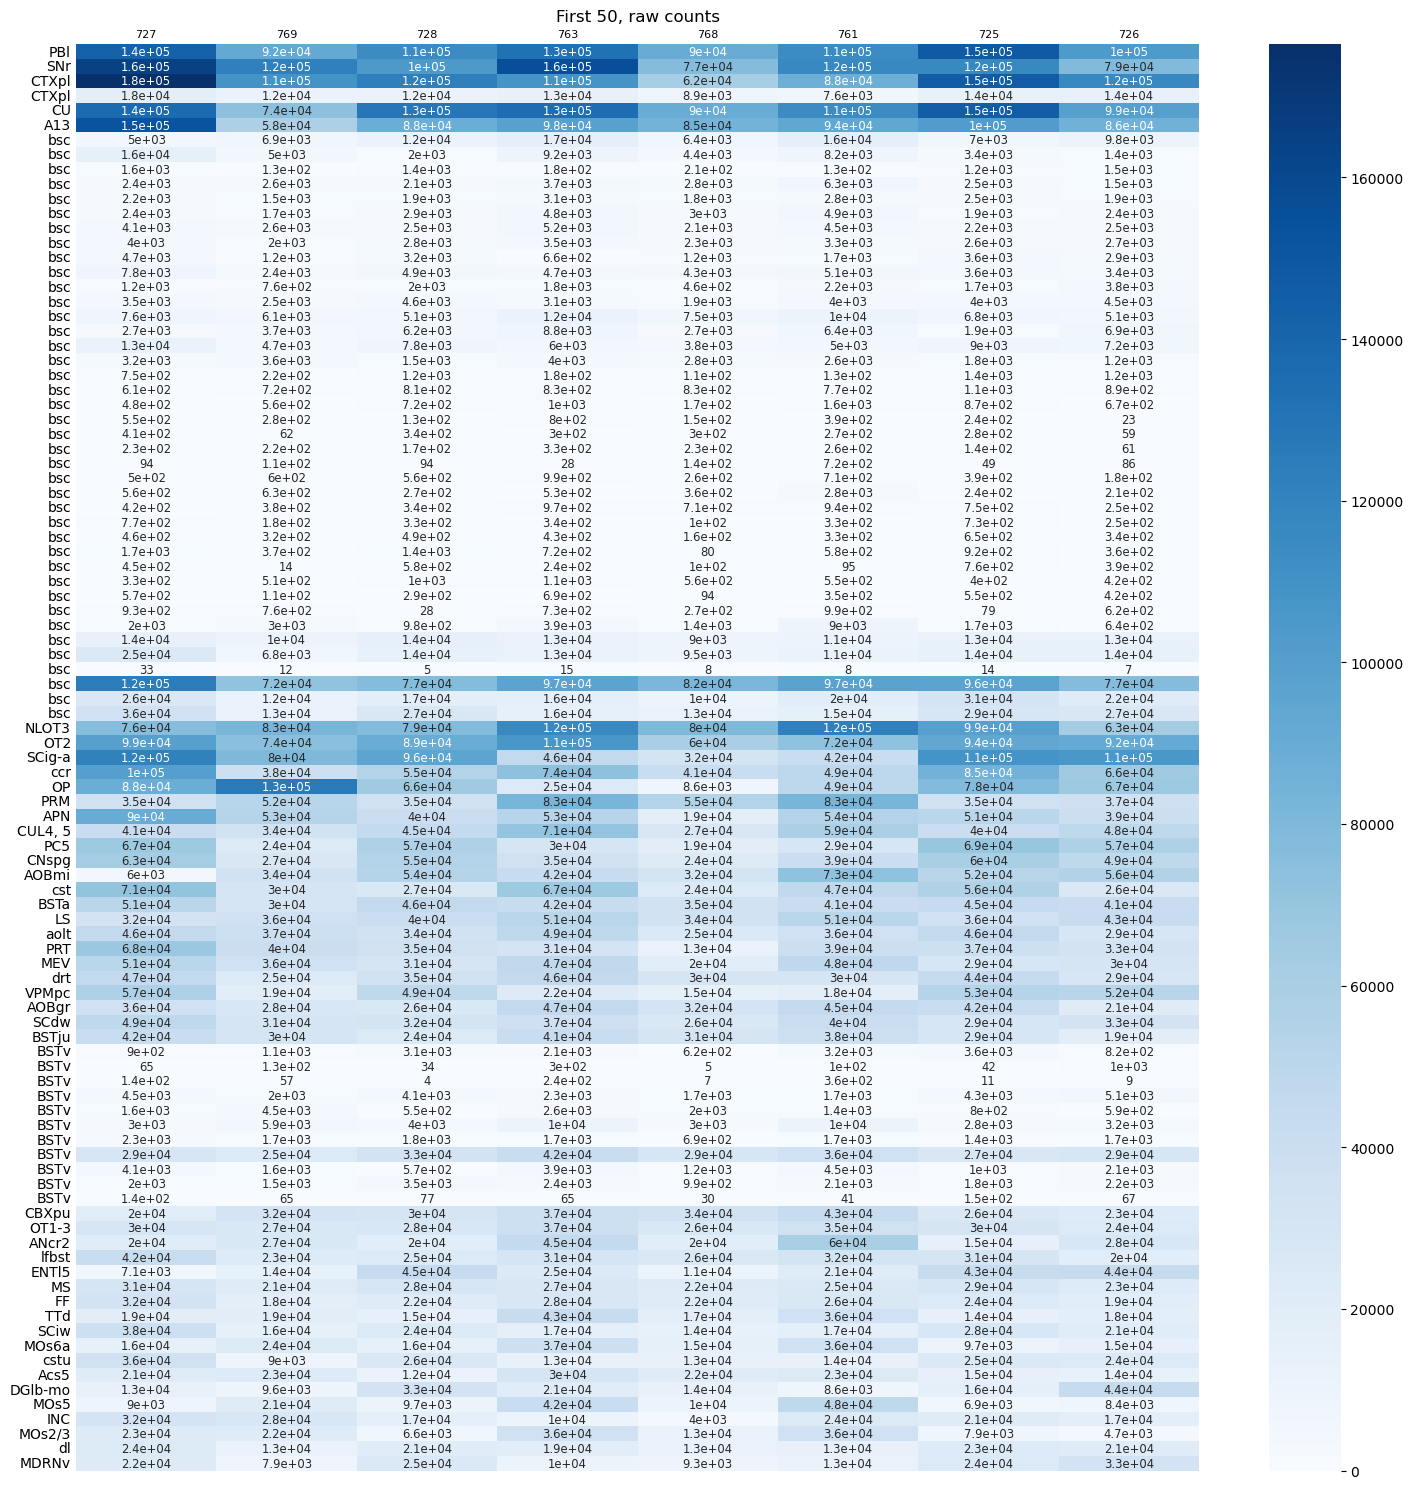

In [194]:
plt.figure(figsize=(15, 15))
plot_heatmap(final_table, sample_names_ordered,  "Blues",)
plt.title('First 50, raw counts')
plt.tight_layout()
plt.savefig(FOLDER_FIGS + 'first_50.svg')

NaNs problem

In [123]:
atlas.get_names([1180, 1183, 1194, 1193, 1134])

KeyError: 1180

## AnaMarta's selection

```
754 Olfactory tubercle OT
961 Piriform area PIR
477 Striatum STR
672 Caudoputamen CP
1022 Globus pallidus, external segment GPe
1031 Globus pallidus, internal segment GPi
975 Edinger-Westphal nucleus EW
872 Dorsal nucleus raphé DR
4 Inferior colliculus IC
83 Inferior olivary complex IO
621 Motor nucleus of trigeminal V
795 Periaqueductal gray PAG
631 Cortical amygdalar area COA
295 Basolateral amygdalar nucleus BLA
23 Anterior amygdalar area AAA
1097 Hypothalamus HY
194 Lateral hypothalamic area LHA
596 Diagonal band nucleus NDB
```

In [205]:
596 in table.id.tolist()

False

In [201]:
structures_oi = [
    754,
    961,
    477,
    975 ,
    872 ,
    4 ,
    83 ,
    621 ,
    795 ,
    631 ,
    295 ,
    23 ,
    1097, 
    596,
]

# get a map_collapse that maps every child of structures_oi to their parent in structures_oi
map_collapse = atlas.get_map_to_parent(structures_oi)

# collapse the count dataframe (first, areas not in structures_oi are kept)
collapsed_table = collapse_structures(table, map_collapse)

# keeps only the structures_oi (areas not in structures_oi are filtered out)
filtered_table = filter_df(collapsed_table, structures_oi)


# finally, get the annotation
final_table = atlas.enrich_df(filtered_table).sort_values(by="id", key=lambda ids: ids.map(lambda id_: structures_oi.index(id_)))

#### Save
final_table.to_csv(FOLDER_FIGS + 'selection.csv')

final_table

,id,726,727,761,728,769,763,725,768,name,acronym
6,961,1977.0,2721.0,3669.0,1941.0,2532.0,3406.0,2018.0,1158.0,Piriform area,PIR
3,477,226131.0,228069.0,232300.0,230700.0,190201.0,275302.0,239269.0,180465.0,Striatum,STR
7,975,3264.0,3198.0,604.0,3118.0,1098.0,734.0,3355.0,400.0,Edinger-Westphal nucleus,EW
0,4,1126.0,1328.0,237.0,1112.0,278.0,394.0,901.0,434.0,Inferior colliculus,IC
1,83,216.0,231.0,95.0,138.0,106.0,60.0,198.0,107.0,Inferior olivary complex,IO
5,795,22379.0,39521.0,29662.0,21010.0,36251.0,11774.0,26749.0,4934.0,Periaqueductal gray,PAG
4,631,13127.0,14107.0,23034.0,16069.0,10857.0,21501.0,16771.0,15907.0,Cortical amygdalar area,COA
2,295,6459.0,9644.0,15256.0,8185.0,11349.0,16780.0,10577.0,10290.0,Basolateral amygdalar nucleus,BLA
8,1097,220065.0,357286.0,268863.0,220729.0,165146.0,280069.0,233657.0,215709.0,Hypothalamus,HY


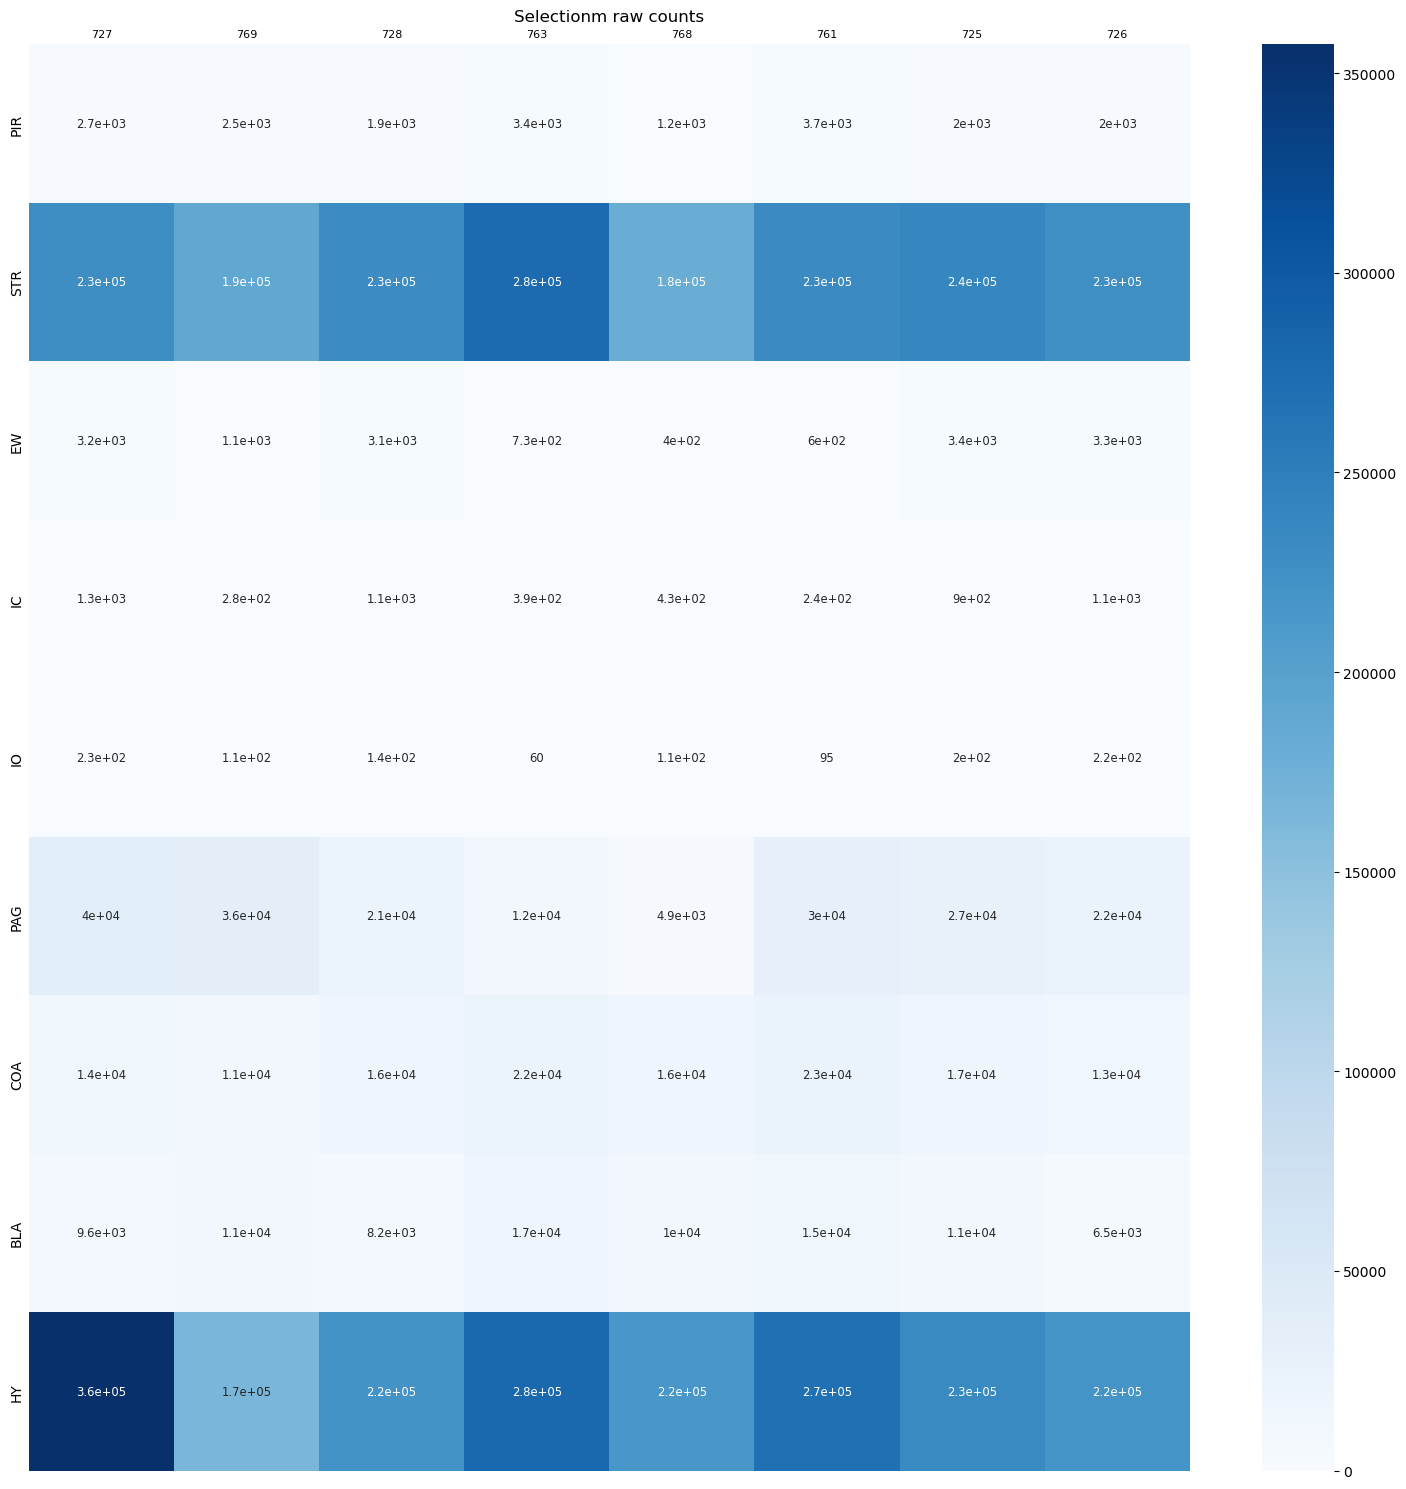

In [196]:
plt.figure(figsize=(15, 15))
plot_heatmap(final_table, sample_names_ordered,  "Blues",)
plt.title('Selectionm raw counts')
plt.tight_layout()
plt.savefig(FOLDER_FIGS + 'selection.svg')

### Log representation

In [197]:
table_log = final_table.copy()
table_log[sample_names_ordered] = table_log[sample_names_ordered].applymap(np.log10)
table_log

,id,726,727,761,728,769,763,725,768,name,acronym
6,961,3.296007,3.434729,3.564548,3.288026,3.403464,3.532245,3.304921,3.063709,Piriform area,PIR
3,477,5.354360,5.358066,5.366049,5.363048,5.279213,5.439809,5.378886,5.256393,Striatum,STR
7,975,3.513750,3.504878,2.781037,3.493876,3.040602,2.865696,3.525693,2.602060,Edinger-Westphal nucleus,EW
0,4,3.051538,3.123198,2.374748,3.046105,2.444045,2.595496,2.954725,2.637490,Inferior colliculus,IC
1,83,2.334454,2.363612,1.977724,2.139879,2.025306,1.778151,2.296665,2.029384,Inferior olivary complex,IO
5,795,4.349841,4.596828,4.472200,4.322426,4.559320,4.070924,4.427308,3.693199,Periaqueductal gray,PAG
4,631,4.118165,4.149435,4.362369,4.205989,4.035710,4.332459,4.224559,4.201588,Cortical amygdalar area,COA
2,295,3.810165,3.984257,4.183441,3.913019,4.054958,4.224792,4.024363,4.012415,Basolateral amygdalar nucleus,BLA
8,1097,5.342551,5.553016,5.429531,5.343859,5.217868,5.447265,5.368579,5.333868,Hypothalamus,HY


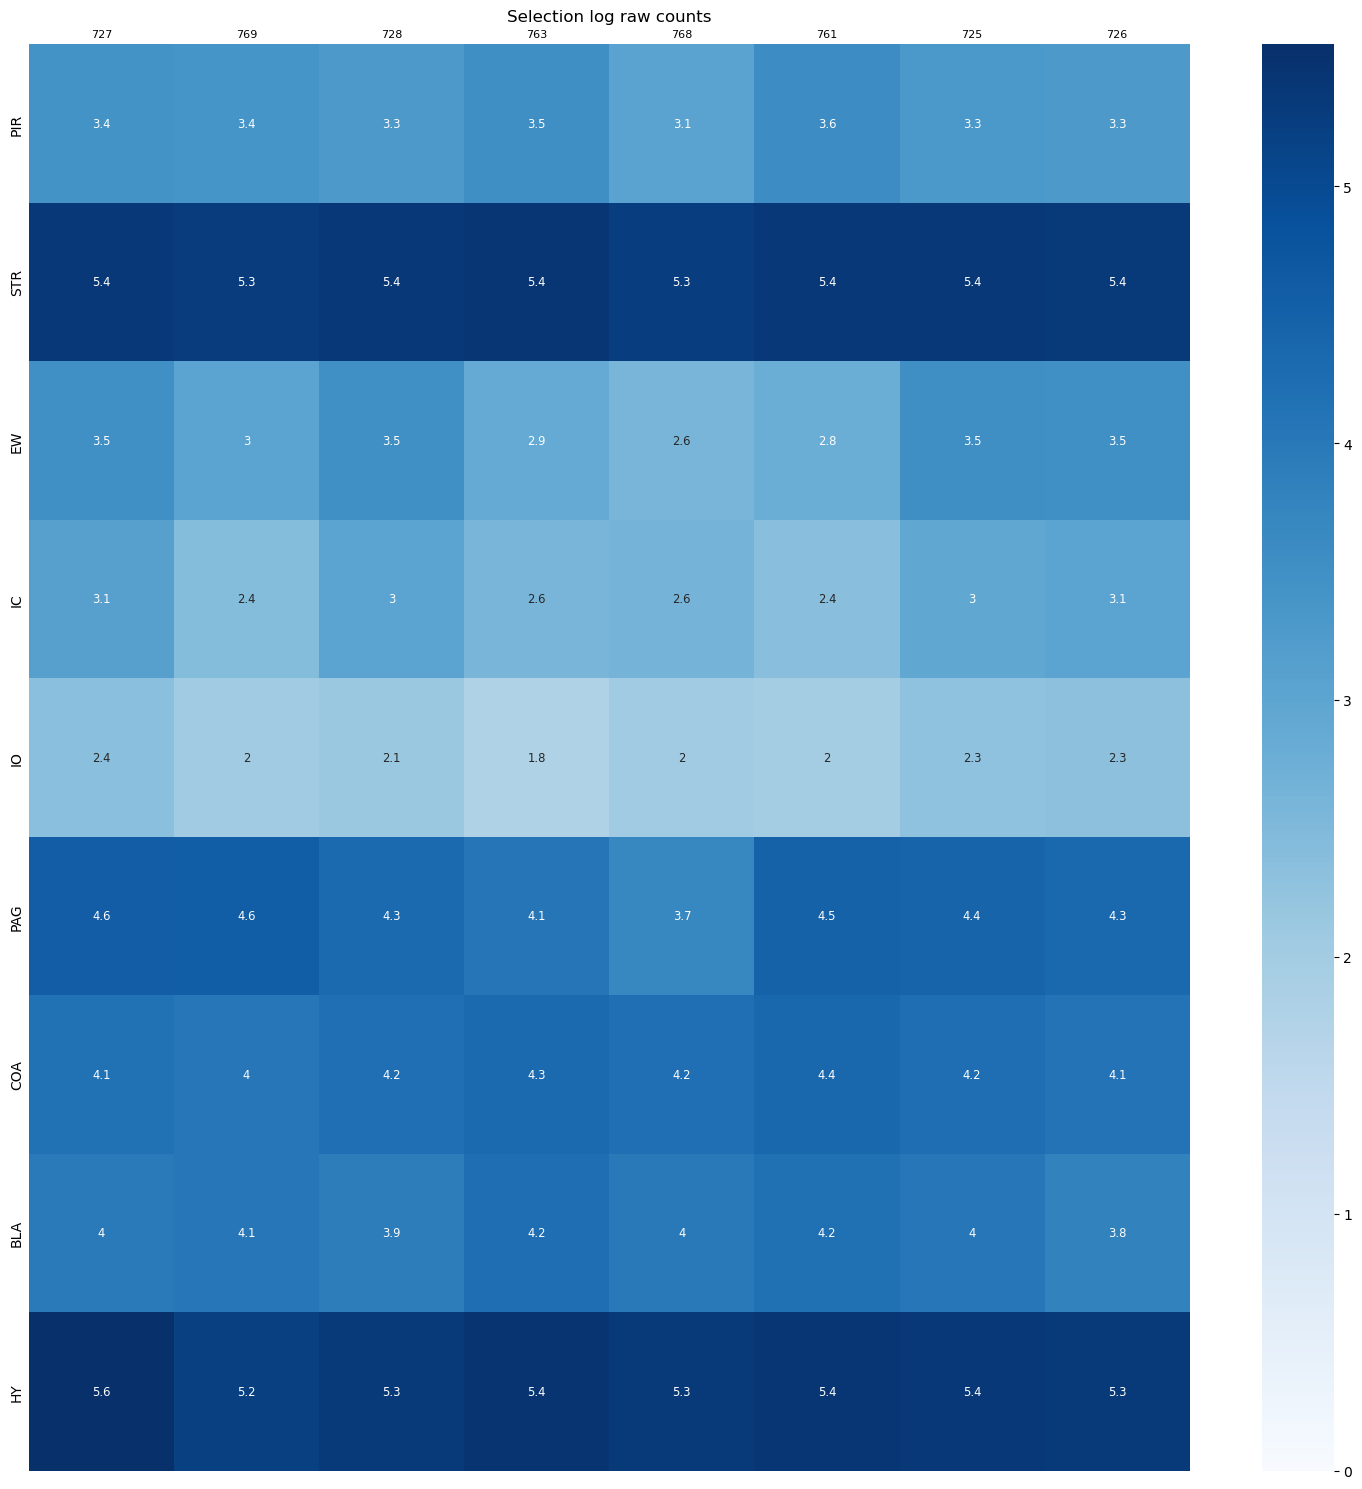

In [198]:
plt.figure(figsize=(15, 15))
plot_heatmap(table_log, sample_names_ordered,  "Blues",)
plt.title('Selection log raw counts')
plt.tight_layout()
plt.savefig(FOLDER_FIGS + 'selection_log.svg')

In [199]:
structures_oi = [
    672,
1022 ,
1031 ,
    194,
]

# get a map_collapse that maps every child of structures_oi to their parent in structures_oi
map_collapse = atlas.get_map_to_parent(structures_oi)

# collapse the count dataframe (first, areas not in structures_oi are kept)
collapsed_table = collapse_structures(table, map_collapse)

# keeps only the structures_oi (areas not in structures_oi are filtered out)
filtered_table = filter_df(collapsed_table, structures_oi)


# finally, get the annotation
final_table = atlas.enrich_df(filtered_table).sort_values(by="id", key=lambda ids: ids.map(lambda id_: structures_oi.index(id_)))

#### Save
final_table.to_csv(FOLDER_FIGS + 'selection_.csv')

final_table

,id,726,727,761,728,769,763,725,768,name,acronym


754,
961,
477,
672,
1022 
1031 
975 
872 
4 
83 
621 
795 
631 
295 
23 
1097 
194 
596

In [54]:
# Set structures of interest
structures_oi = [
    981, 201, 1047, 1070, 1038, 1062, # layers of SS1bf
    353, 337, 345, 369, 361, # somatosensories except SS1bf (329)
    378, 22, 541, 922, 895, # associative areas
    909, # entorhinal areas, which are in Retrohippocampal region (822) 
    985, 993, # motor areas
    184, 1057, 677, 247, 669, 31, 972, 44, 714, 95, 254, # other isocortical
]

```python
'Dorsal nucleus raphe': 872,
'Caudoputamen': 672,
'Striatum': 477,
'Olfactory tubercle': 754,
'Inferior colliculus': 4,
'Periaqueductal gray': 795,
'Inferior olivary complex': 83,
```

In [26]:
atlas.get_children([872])

[]

In [27]:
atlas.get_children([672])

[]

In [28]:
atlas.get_children([477])

[485,
 493,
 275,
 278,
 672,
 56,
 998,
 754,
 481,
 489,
 144,
 458,
 465,
 473,
 549009199,
 242,
 250,
 258,
 266,
 310,
 333,
 23,
 292,
 536,
 544,
 551,
 559,
 1105,
 403,
 411,
 418,
 426,
 472,
 480,
 487,
 435]

In [31]:
atlas.get_children([754])

[481, 489, 144, 458, 465, 473]

In [32]:
atlas.get_children([4])

[811, 820, 828]

In [33]:
atlas.get_children([795])

[50, 67, 587]

In [34]:
atlas.get_children([83])

[]

In [36]:
structures_oi = atlas.get_children([872, 672, 477, 754, 4, 795, 83])

In [23]:
atlas.map_name_to_id

{'brain': 997,
 'Basic cell groups and regions': 8,
 'Cerebrum': 567,
 'Cerebral cortex': 688,
 'Cortical plate': 695,
 'Isocortex': 315,
 'Frontal pole, cerebral cortex': 184,
 'Frontal pole, layer 1': 68,
 'Frontal pole, layer 2/3': 667,
 'Frontal pole, layer 5': 526157192,
 'Frontal pole, layer 6a': 526157196,
 'Frontal pole, layer 6b': 526322264,
 'Somatomotor areas': 500,
 'Somatomotor areas, Layer 1': 107,
 'Somatomotor areas, Layer 2/3': 219,
 'Somatomotor areas, Layer 5': 299,
 'Somatomotor areas, Layer 6a': 644,
 'Somatomotor areas, Layer 6b': 947,
 'Primary motor area': 985,
 'Primary motor area, Layer 1': 320,
 'Primary motor area, Layer 2/3': 943,
 'Primary motor area, Layer 5': 648,
 'Primary motor area, Layer 6a': 844,
 'Primary motor area, Layer 6b': 882,
 'Secondary motor area': 993,
 'Secondary motor area, layer 1': 656,
 'Secondary motor area, layer 2/3': 962,
 'Secondary motor area, layer 5': 767,
 'Secondary motor area, layer 6a': 1021,
 'Secondary motor area, layer

In [22]:
# Set structures for normalization. These structures will be the 100% of the counts (number, hemisphere, included/excluded)

norm_structures = [
    981, 201, 1047, 1070, 1038, 1062, # layers of SS1bf
    353, 337, 345, 369, 361, # somatosensories except SS1bf (329)
    378, 22, 541, 922, 895, # associative areas
    909, # entorhinal areas, which are in Retrohippocampal region (822) 
    985, 993, # motor areas
    184, 1057, 677, 247, 669, 31, 972, 44, 714, 95, 254, # other isocortical
]

In [41]:
norm_structures = list(atlas.map_names.keys())

In [42]:
# Set hemisphere
norm_hemispheres = ['RH'] # or ['LH'] or ['RH', 'LH']

# Set include/exclude
norm_exclude = False # True or False (False means will take as 100% the regions listed,True will take as 100% everything else)

In [43]:
df = pd.read_feather(path).value_counts().reset_index().rename(columns={0:'count'})

In [44]:
df

,id,count
0,0,755885
1,811,116677
2,829,106064
3,876,103906
4,927,99434
...,...,...
547,208,9
548,1,7
549,95,3
550,206,2


In [ ]:
# collapse the count dataframe (first, areas not in structures_oi are kept)
collapsed_table = collapse_structures(table, map_collapse)

In [181]:
for count in counts:
    print(975 in count.id.tolist())

False
False
False
False
False
False
False
False


In [179]:
975 in counts[0].id.tolist()

False

In [184]:
atlas.get_map_from("graph_order")[849]

975